In [3]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
import graph
from graph import *
from node import *
from part import *
from sklearn.model_selection import train_test_split

# Suppose you have your own classes:
# Graph, Node, Part
# For illustration, here are minimal stubs:

############################################################
# 1) Prepare sample graphs
############################################################
with open('./data/graphs.dat', 'rb') as file:
    train_graphs_list: List[Graph] = pickle.load(file)
    train_graphs_list, test_graphs = train_test_split(train_graphs_list, test_size=0.2, random_state=42)



############################################################
# 2) Build a PyTorch Dataset
############################################################
class LinkPredictionDataset(Dataset):

    """
    Creates positive/negative samples from each Graph.
    For each Graph:
      - Collect all nodes
      - For every pair (i, j), check if it's an edge (label=1) or not (label=0)
    """
    def __init__(self, graphs: List[Graph]):
        super().__init__()
        self.samples = []

        for g in graphs:
            # Get the nodes and edges
            node_list = g.get_nodes()          # List[Node]
            edge_list = g.get_edges()          # List of (Node, Node)
            edge_set = self.get_edge_list(edge_list)        # for quick membership checks

            # Map node ID -> (part_id, family_id)
            node_id_to_features = {}
            for node in node_list:
                node_id_to_features[node.get_id()] = (
                    node.get_part().get_part_id(),
                    node.get_part().get_family_id()
                )

            # We'll gather all node IDs from the node list
            node_ids = [n.get_id() for n in node_list]
            id_to_node = {n.get_id(): n for n in node_list}

            # Create all (i, j) pairs
            for i in node_ids:
                for j in node_ids:
                    if i == j:
                        continue
                    part_i, fam_i = node_id_to_features[i]
                    part_j, fam_j = node_id_to_features[j]

                    # Sort the pair for an undirected edge check
                    pair = tuple(sorted([id_to_node[i], id_to_node[j]],
                                        key=lambda x: x.get_id()))
                    label = 1 if pair in edge_set else 0

                    self.samples.append((int(part_i), int(fam_i), int(part_j), int(fam_j), int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]  # (part_i, fam_i, part_j, fam_j, label)
    def get_edge_list(self, __edges: Dict[Node, List[Node]]):
        edge_pairs = set()  # use a set to avoid duplicates

        for src, neighbors in __edges.items():
            for dst in neighbors:
                # Sort the pair so that (NodeA, NodeB) == (NodeB, NodeA)
                sorted_pair = tuple(sorted([src, dst], key=lambda n: n.get_id()))
                edge_pairs.add(sorted_pair)

        return edge_pairs  # Now we have a list of (Node, Node) pairs


############################################################
# 3) Create the dataset & figure out vocab size
############################################################
all_part_ids = []
all_family_ids = []
for graph in train_graphs_list:
    for n in graph.get_nodes():
        all_part_ids.append(int(n.get_part().get_part_id()))
        all_family_ids.append(int(n.get_part().get_family_id()))

part_vocab_size = max(all_part_ids) + 1
family_vocab_size = max(all_family_ids) + 1

dataset = LinkPredictionDataset(train_graphs_list)
print("Number of training pairs:", len(dataset))

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


############################################################
# 4) Define a simple model for link prediction
############################################################
class EdgePredictor(nn.Module):
    def __init__(self, part_vocab_size, family_vocab_size,
                 embed_dim=16, hidden_dim=32):
        super().__init__()
        self.part_embedding = nn.Embedding(part_vocab_size, embed_dim)
        self.family_embedding = nn.Embedding(family_vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim * 4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, part_i, fam_i, part_j, fam_j):
        """
        part_i, fam_i, part_j, fam_j are integer tensors
        of shape (batch_size,).
        """
        pi = self.part_embedding(part_i)  # (B, embed_dim)
        fi = self.family_embedding(fam_i) # (B, embed_dim)
        pj = self.part_embedding(part_j)  # (B, embed_dim)
        fj = self.family_embedding(fam_j) # (B, embed_dim)

        x = torch.cat([pi, fi, pj, fj], dim=1)  # (B, 4*embed_dim)
        x = self.relu(self.fc1(x))             # (B, hidden_dim)
        x = self.fc2(x)                        # (B, 1)
        return x.squeeze(1)  # (B,)


############################################################
# 5) Train the model
############################################################
model = EdgePredictor(part_vocab_size, family_vocab_size, embed_dim=16, hidden_dim=32)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 200  # For demo, keep it smaller
model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    for batch in dataloader:
        part_i, fam_i, part_j, fam_j, label = batch
        # Convert to Long / Float for embeddings + BCE
        part_i = part_i.long()
        fam_i  = fam_i.long()
        part_j = part_j.long()
        fam_j  = fam_j.long()
        label  = label.float()

        optimizer.zero_grad()
        logits = model(part_i, fam_i, part_j, fam_j)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")


############################################################
# 6) Predict edges on NEW sets of (part_id, family_id)
############################################################


@torch.no_grad()
def predict_edges(model, parts, threshold=0.5):
    """
    part_family_list: list of (part_id, family_id)
    We will return a list of edges (i, j) for i < j if predicted prob > threshold.
    """
    model.eval()
    n = len(parts)
    graph = Graph()

    for i in range(n):
        for j in range(i + 1, n):
            part_i, fam_i = int(parts[i].get_part_id()), int(parts[i].get_family_id())
            part_j, fam_j = int(parts[j].get_part_id()), int(parts[j].get_family_id())

            pi = torch.tensor([part_i], dtype=torch.long)
            fi = torch.tensor([fam_i], dtype=torch.long)
            pj = torch.tensor([part_j], dtype=torch.long)
            fj = torch.tensor([fam_j], dtype=torch.long)

            logit = model(pi, fi, pj, fj)
            prob = torch.sigmoid(logit)
            if prob.item() > threshold:
                graph.add_edge(parts[i], parts[j])
                graph.add_edge(parts[j], parts[i])

    return graph


# Example of new data:
test_parts = train_graphs_list[0].get_parts()

predicted = predict_edges(model, list(test_parts), threshold=0.5)
train_graphs_list[0].draw()
predicted.draw()



Number of training pairs: 511736


KeyboardInterrupt: 

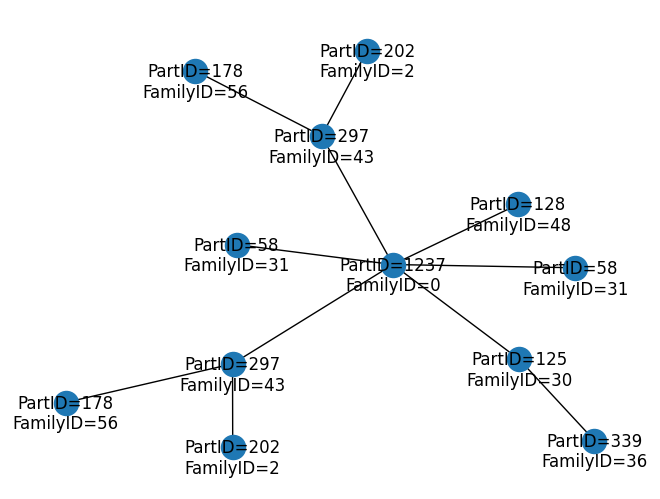

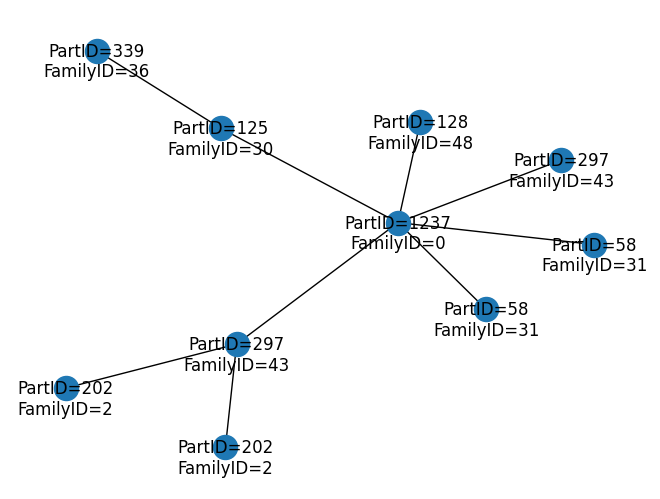

In [5]:
@torch.no_grad()
def predict_edges(model, parts, threshold=0.5):
    """
    part_family_list: list of (part_id, family_id)
    We will return a list of edges (i, j) for i < j if predicted prob > threshold.
    """
    model.eval()
    n = len(parts)
    graph = Graph()

    for i in range(n):
        for j in range(i+1, n):
            part_i, fam_i = int(parts[i].get_part_id()), int(parts[i].get_family_id())
            part_j, fam_j = int(parts[j].get_part_id()), int(parts[j].get_family_id())

            pi = torch.tensor([part_i], dtype=torch.long)
            fi = torch.tensor([fam_i],  dtype=torch.long)
            pj = torch.tensor([part_j], dtype=torch.long)
            fj = torch.tensor([fam_j],  dtype=torch.long)

            logit = model(pi, fi, pj, fj)
            prob = torch.sigmoid(logit)
            if prob.item() > threshold:
                graph.add_edge(parts[i], parts[j])
                graph.add_edge(parts[j], parts[i])

    return graph

# Example of new data:
test_parts = train_graphs_list[3].get_parts()

predicted = predict_edges(model, list(test_parts), threshold=0.5)
train_graphs_list[3].draw()
predicted.draw()

In [4]:
import torch.nn.functional as F
with open('./data/graphs.dat', 'rb') as file:
    train_graphs_list: List[Graph] = pickle.load(file)
    train_graphs_list, test_graphs = train_test_split(train_graphs_list, test_size=0.2, random_state=42)
class GraphPredictor(nn.Module):
    def __init__(self, part_vocab_size, family_vocab_size, embed_dim=1, gnn_hidden_dim=32):
        super().__init__()
        self.part_embedding = nn.Embedding(part_vocab_size, embed_dim)
        self.family_embedding = nn.Embedding(family_vocab_size, embed_dim)
        self.gnn_hidden_dim = gnn_hidden_dim

        # MLP for initial node features
        self.node_mlp = nn.Sequential(
            nn.Linear(embed_dim * 2, gnn_hidden_dim),
            nn.ReLU()
        )

        # Graph neural network layers
        self.gnn1 = nn.Linear(gnn_hidden_dim, gnn_hidden_dim)
        #self.gnn2 = nn.Linear(gnn_hidden_dim, gnn_hidden_dim)

        # Final MLP for edge prediction
        self.edge_mlp = nn.Sequential(
            nn.Linear(gnn_hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, part_ids, family_ids):
        """
        part_ids, family_ids: Tensors of shape (num_nodes,)
        adjacency_matrix: Tensor of shape (num_nodes, num_nodes)
        """
        # Node feature initialization
        part_emb = self.part_embedding(part_ids)  # (num_nodes, embed_dim)
        family_emb = self.family_embedding(family_ids)  # (num_nodes, embed_dim)
        node_features = torch.cat([part_emb, family_emb], dim=1)  # (num_nodes, embed_dim * 2)
        node_features = self.node_mlp(node_features)  # (num_nodes, gnn_hidden_dim)

        # GNN layers
        #for gnn_layer in [self.gnn1]:
        #    aggregated_messages = adjacency_matrix @ node_features  # (num_nodes, gnn_hidden_dim)
         #   node_features = F.relu(gnn_layer(aggregated_messages))  # (num_nodes, gnn_hidden_dim)
          #  print(node_features)
           # print(aggregated_messages)

        # Pairwise edge prediction
        num_nodes = node_features.size(0)
        expanded_features = node_features.unsqueeze(1).repeat(1, num_nodes, 1)  # (num_nodes, num_nodes, gnn_hidden_dim)
        concatenated_features = torch.cat([expanded_features, expanded_features.transpose(0, 1)], dim=2)  # (num_nodes, num_nodes, gnn_hidden_dim * 2)

        edge_logits = self.edge_mlp(concatenated_features).squeeze(-1)  # (num_nodes, num_nodes)
        return edge_logits

# Modify the training loop
def train_graph_predictor(model, train_graphs_list, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        print("EPOCH: ", epoch)
        total_loss = 0.0

        for graph in train_graphs_list:
            optimizer.zero_grad()

            # Get nodes and sort them by part_id and family_id
            nodes = sorted(
                graph.get_nodes(),
                key=lambda node: (node.get_part().get_part_id(), node.get_part().get_family_id())
            )

            # Extract part IDs and family IDs in sorted order
            part_ids = torch.tensor([int(node.get_part().get_part_id()) for node in nodes], dtype=torch.long)
            family_ids = torch.tensor([int(node.get_part().get_family_id()) for node in nodes], dtype=torch.long)

            # Get part order based on sorted nodes
            part_order = tuple(node.get_part() for node in nodes)

            # Get the adjacency matrix using the sorted part order
            adjacency_matrix = torch.tensor(graph.get_adjacency_matrix(part_order), dtype=torch.float32)

            # Predict adjacency matrix
            logits = model(part_ids, family_ids)
            target = adjacency_matrix.flatten()  # Flatten adjacency matrix for loss computation

            # Compute loss
            loss = criterion(logits.flatten(), target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_graphs_list)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


# Instantiate and train the new model
model = GraphPredictor(part_vocab_size, family_vocab_size, embed_dim=1, gnn_hidden_dim=32)
optimizer = optim.Adam(model.parameters(), lr=0.001)


criterion = nn.BCEWithLogitsLoss()

train_graph_predictor(model, train_graphs_list, optimizer, criterion, epochs=100)

# Prediction for a new graph
@torch.no_grad()
def predict_graph(model, graph, threshold=0.5):
    part_ids = torch.tensor([int(node.get_part().get_part_id()) for node in graph.get_nodes()], dtype=torch.long)
    family_ids = torch.tensor([int(node.get_part().get_family_id()) for node in graph.get_nodes()], dtype=torch.long)
    

    logits = model(part_ids, family_ids)
    probabilities = torch.sigmoid(logits)
    print(probabilities)
    predicted_adjacency = (probabilities > threshold).float()
    return predicted_adjacency

predicted_adjacency = predict_graph(model, train_graphs_list[0])
part_order = tuple(node.get_part() for node in train_graphs_list[0].get_nodes())
print(len(train_graphs_list[0].get_nodes()))
print(train_graphs_list[0].get_adjacency_matrix(part_order))
print(predicted_adjacency)



EPOCH:  0
Epoch 1/100 - Loss: 0.2811
EPOCH:  1
Epoch 2/100 - Loss: 0.1675
EPOCH:  2
Epoch 3/100 - Loss: 0.1422
EPOCH:  3
Epoch 4/100 - Loss: 0.1282
EPOCH:  4
Epoch 5/100 - Loss: 0.1187
EPOCH:  5
Epoch 6/100 - Loss: 0.1125
EPOCH:  6
Epoch 7/100 - Loss: 0.1078
EPOCH:  7
Epoch 8/100 - Loss: 0.1040
EPOCH:  8
Epoch 9/100 - Loss: 0.1006
EPOCH:  9
Epoch 10/100 - Loss: 0.0979
EPOCH:  10
Epoch 11/100 - Loss: 0.0957
EPOCH:  11
Epoch 12/100 - Loss: 0.0938
EPOCH:  12
Epoch 13/100 - Loss: 0.0920
EPOCH:  13
Epoch 14/100 - Loss: 0.0903
EPOCH:  14
Epoch 15/100 - Loss: 0.0890
EPOCH:  15
Epoch 16/100 - Loss: 0.0878
EPOCH:  16
Epoch 17/100 - Loss: 0.0867
EPOCH:  17
Epoch 18/100 - Loss: 0.0857
EPOCH:  18
Epoch 19/100 - Loss: 0.0849
EPOCH:  19
Epoch 20/100 - Loss: 0.0841
EPOCH:  20
Epoch 21/100 - Loss: 0.0834
EPOCH:  21
Epoch 22/100 - Loss: 0.0827
EPOCH:  22
Epoch 23/100 - Loss: 0.0823
EPOCH:  23
Epoch 24/100 - Loss: 0.0817
EPOCH:  24
Epoch 25/100 - Loss: 0.0813
EPOCH:  25
Epoch 26/100 - Loss: 0.0808
EPOCH

Lets see if the model predicts symmetric adj. matrix

In [6]:
# Check if the predicted adjacency matrix is symmetric
is_symmetric = torch.allclose(predicted_adjacency, predicted_adjacency.T, atol=1e-6)
print(f"Is the predicted adjacency matrix symmetric? {is_symmetric}")


Is the predicted adjacency matrix symmetric? True


The target is also symmetric :) 

In [7]:
part_order = tuple(node.get_part() for node in train_graphs_list[0].get_nodes())
            
            # Call get_adjacency_matrix with part_order
adjacency_matrix = torch.tensor(train_graphs_list[0].get_adjacency_matrix(part_order), dtype=torch.float32)
is_symmetric = torch.allclose(adjacency_matrix, adjacency_matrix.T, atol=1e-6)
print(f"Is the predicted adjacency matrix symmetric? {is_symmetric}")

Is the predicted adjacency matrix symmetric? True


Lets see where the prediction on a sample (first) differs from target

In [8]:
print(train_graphs_list[0].get_adjacency_matrix(part_order))
print(predicted_adjacency)
actual_adjacency = torch.tensor(train_graphs_list[0].get_adjacency_matrix(part_order), dtype=torch.float32)
difference = actual_adjacency - predicted_adjacency  # Differences (-1, 0, or 1)

# Find indices where they differ
differing_indices = torch.nonzero(difference, as_tuple=True)
differing_values_actual = actual_adjacency[differing_indices]
differing_values_predicted = predicted_adjacency[differing_indices]

# Print results
print("Differing Indices:", list(zip(differing_indices[0].tolist(), differing_indices[1].tolist())))
print("Actual Values at Differing Indices:", differing_values_actual.tolist())
print("Predicted Values at Differing Indices:", differing_values_predicted.tolist())

[[0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [1 1 1 1 1 0]]
tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 0.]])
Differing Indices: []
Actual Values at Differing Indices: []
Predicted Values at Differing Indices: []


Evaluation of model on test data (20% of all graphs)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

@torch.no_grad()
def evaluate_model(model, graph, threshold=0.5):
    """
    Evaluate the model on a single graph.
    
    Args:
        model: Trained model.
        graph: Graph object to evaluate.
        threshold: Threshold for classifying edges (default: 0.5).
    
    Returns:
        dict: Dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Get sorted part IDs and family IDs
    nodes = sorted(
        graph.get_nodes(),
        key=lambda node: (node.get_part().get_part_id(), node.get_part().get_family_id())
    )
    part_ids = torch.tensor([int(node.get_part().get_part_id()) for node in nodes], dtype=torch.long)
    family_ids = torch.tensor([int(node.get_part().get_family_id()) for node in nodes], dtype=torch.long)

    # Get sorted part order and true adjacency matrix
    part_order = tuple(node.get_part() for node in nodes)
    true_adjacency = torch.tensor(graph.get_adjacency_matrix(part_order), dtype=torch.float32)

    # Predict adjacency matrix
    logits = model(part_ids, family_ids)
    probabilities = torch.sigmoid(logits)
    predicted_adjacency = (probabilities > threshold).float()

    # Flatten matrices for metric calculation
    true_labels = true_adjacency.flatten().numpy()
    predicted_labels = predicted_adjacency.flatten().numpy()

    # Calculate metrics
    metrics = {
        "accuracy": accuracy_score(true_labels, predicted_labels),
        "precision": precision_score(true_labels, predicted_labels, zero_division=0),
        "recall": recall_score(true_labels, predicted_labels, zero_division=0),
        "f1_score": f1_score(true_labels, predicted_labels, zero_division=0),
    }
    return metrics

# Evaluate on all training graphs
@torch.no_grad()
def evaluate_on_dataset(model, graphs, threshold=0.5):
    all_metrics = []

    for graph in graphs:
        metrics = evaluate_model(model, graph, threshold=threshold)
        all_metrics.append(metrics)

    # Aggregate metrics
    avg_metrics = {
        "accuracy": sum(m["accuracy"] for m in all_metrics) / len(all_metrics),
        "precision": sum(m["precision"] for m in all_metrics) / len(all_metrics),
        "recall": sum(m["recall"] for m in all_metrics) / len(all_metrics),
        "f1_score": sum(m["f1_score"] for m in all_metrics) / len(all_metrics),
    }
    return avg_metrics

# Perform evaluation
avg_metrics = evaluate_on_dataset(model, test_graphs, threshold=0.5)
print("Evaluation Metrics:")
print(avg_metrics)


Evaluation Metrics:
{'accuracy': 0.9600420838507265, 'precision': 0.8899902563324968, 'recall': 0.953486426632378, 'f1_score': 0.9145918045513092}
